# Feature Engineering

### Goal :
- Goal is to create a one master dataset that include Stock Price Actions + Technical Indicators + Sentiments.
- Create one Function that can add all this features to a dataset and store intermidiate results if needed from the StockData CSV or from the internet.

## 1. Data Collector & Cleaner Functions

###  Stock Data

In [37]:
# Use YFinance env for collecting Data

In [11]:
def CollectAndCleanStockData(ticker_symbol, start, end, save=True):
    """
    Fetches, cleans, and optionally saves historical stock data from Yahoo Finance.

    Parameters:
    -----------
    ticker_symbol : str
        The stock ticker (e.g., 'AAPL' for Apple Inc.)
    start : str
        Start date for data collection in 'YYYY-MM-DD' format.
    end : str
        End date for data collection in 'YYYY-MM-DD' format.
    save : bool, optional
        Whether to save the cleaned data as a CSV file (default is True).

    Returns:
    --------
    pd.DataFrame or None
        Cleaned stock data with 'Date' as index, or None on failure.
    """
    import yfinance as yf
    import pandas as pd
    import os

    try:
        # Step 1: Download historical stock data
        stock_data = yf.download(ticker_symbol, start=start, end=end)

        if stock_data is None or stock_data.empty:
            print(f"❌ No data downloaded for {ticker_symbol}.")
            return None

        # Step 2: Flatten MultiIndex if needed
        if isinstance(stock_data.columns, pd.MultiIndex):
            stock_data.columns = stock_data.columns.get_level_values(0)

        stock_data.columns.name = None

        # Step 3: Reset index to access 'Date' as a column
        stock_data = stock_data.reset_index()

        # Step 4: Ensure proper datetime formatting and drop bad rows
        stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
        stock_data = stock_data.dropna(subset=['Date'])

        # Step 5: Convert all other columns to float
        float_columns = stock_data.columns.difference(['Date'])
        stock_data[float_columns] = stock_data[float_columns].apply(pd.to_numeric, errors='coerce')

        # Step 6: Drop rows with NaNs in all float columns
        stock_data = stock_data.dropna(subset=float_columns, how='all')

        # Step 7: Set 'Date' as index
        stock_data.set_index('Date', inplace=True)

        # Step 8: Save to CSV if required
        if save:
            os.makedirs("../data/stock_data", exist_ok=True)
            output_path = f"../data/stock_data/{ticker_symbol}_{start}_to_{end}_cleaned.csv"
            stock_data.to_csv(output_path,index=True)
            print(f"✅ Saved cleaned stock data: {output_path}")

        return stock_data

    except Exception as e:
        print(f"❌ Exception during stock data collection and cleaning for {ticker_symbol}: {e}")
        return None

In [12]:
stock_data = CollectAndCleanStockData('SYK','2023-05-20','2025-05-19',save=True)


[*********************100%***********************]  1 of 1 completed

✅ Saved cleaned stock data: ../data/stock_data/SYK_2023-05-20_to_2025-05-19_cleaned.csv


In [3]:
stock_data

,Close,High,Low,Open,Volume
Date,,,,,
2023-05-22,280.647339,285.992144,280.196195,281.039613,1189700
2023-05-23,268.869110,279.794109,266.819448,278.862460,2163300
2023-05-24,267.299957,269.830184,264.995303,267.731468,1181800
2023-05-25,267.143066,268.829874,262.592627,267.790333,1159100
2023-05-26,267.319611,270.526524,266.093734,267.819778,1091700
...,...,...,...,...,...
2025-05-12,388.079987,392.420013,386.500000,389.070007,1359300
2025-05-13,387.529999,390.459991,385.779999,388.670013,862600
2025-05-14,386.320007,388.019989,384.760010,386.959991,1107700


### News Data

In [1]:
def get_news_api():
    """
    Loads the NewsAPI key from a JSON configuration file.

    Returns:
        str: The NewsAPI key used for making authenticated requests.
    """
    import json
    # Open the configuration file and load the contents
    with open("..\\config.json") as config_file:
        config = json.load(config_file)

    # Retrieve the NewsAPI key from the configuration
    NEWS_API_KEY = config["NEWSAPI_KEY"]
    
    # Return the API key
    return NEWS_API_KEY

In [2]:
import pandas as pd

def NewsDataCollector(ticker: str, from_date: str, to_date: str, save: bool = True) -> pd.DataFrame:
    """
    Fetch financial news articles for a given stock ticker or company name using NewsAPI.org.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker or company name (e.g., 'AAPL' or 'Apple Inc.')
    from_date : str
        Start date for news collection in 'YYYY-MM-DD' format.
    to_date : str
        End date for news collection in 'YYYY-MM-DD' format.
    save : bool, optional
        Whether to save the resulting news DataFrame to CSV. Defaults to True.
    
    Returns:
    --------
    pd.DataFrame
        A DataFrame containing news headlines, descriptions, and metadata.
    
    Example:
    --------
    NewsDataCollector('AAPL', '2024-04-01', '2024-04-10')
    """
    import requests
    from datetime import datetime
    import os

    # Define target directory for saving news CSVs
    output_dir = '../data/news_data'
    os.makedirs(output_dir, exist_ok=True)

    # Get your NewsAPI API key securely (assumed to be implemented in a separate function)
    API_KEY = get_news_api()
    
    # Construct the search query
    query = f"{ticker} stock"
    url = (
        f"https://newsapi.org/v2/everything?"
        f"q={query}&from={from_date}&to={to_date}&language=en&"
        f"sortBy=publishedAt&pageSize=100&apiKey={API_KEY}"
    )
    
    # Send GET request to NewsAPI
    response = requests.get(url)
    data = response.json()
    articles = data.get('articles', [])

    # Handle case where no news is returned
    if not articles:
        print(f"⚠️ No articles found for {ticker} from {from_date} to {to_date}.")
        return pd.DataFrame()
    
    # Construct DataFrame from article list
    news_dataframe = pd.DataFrame([{
        'ticker': ticker.upper(),
        'source': article['source']['name'],
        'title': article['title'],
        'description': article['description'],
        'content': article['content'],
        'url': article['url'],
        'publishedAt': pd.to_datetime(article['publishedAt'])
    } for article in articles])
    
    # Save to CSV if required
    if save:
        filename = f"{ticker.upper()}_{from_date}_to_{to_date}.csv"
        output_path = f"{output_dir}/{filename}"
        news_dataframe.to_csv(output_path, index=False)
        print(f"✅ News saved: {output_path}")

    return news_dataframe

In [33]:
def NewsDataCleaner(news_df, save=True):
    """
    Cleans a news DataFrame or loads and cleans a news CSV file.
    If saved, appends "_cleaned.csv" to filename or uses ticker-based auto-naming.

    Parameters:
    -----------
    news_df : str or pd.DataFrame
        - If str: path to the CSV file exported from News API.
        - If DataFrame: directly cleans the provided DataFrame.
    save : bool
        Whether to save the cleaned DataFrame as a CSV file.

    Returns:
    --------
    pd.DataFrame or None
        Cleaned news DataFrame with:
        - Null titles/descriptions removed
        - Duplicate URLs dropped
        - Combined 'clean_text' column (lowercased, punctuation removed)
        - Unnecessary columns dropped
    """
    import pandas as pd
    import os

    try:
        from_file = False

        # Load from CSV if a file path is given
        if not isinstance(news_df, pd.DataFrame):
            print("📄 Loading news data from CSV...")
            base, _ = os.path.splitext(news_df)
            final_path = base + '_cleaned.csv'
            news_df = pd.read_csv(news_df, parse_dates=['publishedAt'])
            from_file = True
        else:
            print("🧹 Cleaning existing news DataFrame...")

        # Drop rows missing 'title' or 'description'
        news_df.dropna(subset=['title', 'description'], inplace=True)

        # Remove duplicates based on 'url'
        news_df.drop_duplicates(subset='url', inplace=True)

        # Create normalized text field
        news_df['clean_text'] = news_df['title'] + '. ' + news_df['description']
        news_df['clean_text'] = news_df['clean_text'].str.lower()
        news_df['clean_text'] = news_df['clean_text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

        # Reset index after cleanup
        news_df.reset_index(drop=True, inplace=True)

        # Drop unnecessary fields
        for col in ['source', 'url']:
            if col in news_df.columns:
                news_df.drop(col, axis=1, inplace=True)

        # Determine save path
        if save:
            if not from_file:
                ticker = str(news_df['ticker'].iloc[0]) if 'ticker' in news_df.columns else "news"
                final_path = f"../data/news_data/{ticker}_cleaned.csv"

            # Ensure the directory exists
            os.makedirs(os.path.dirname(final_path), exist_ok=True)

            # Save cleaned data
            news_df.to_csv(final_path, index=False)
            print(f"✅ Cleaned news data saved to: {final_path}")

        return news_df

    except Exception as e:
        print(f"⚠️ Error processing news data: {e}")
        return None

In [34]:
news_data = NewsDataCleaner(NewsDataCollector('Stryker Corporation', '2025-05-20', '2023-05-20'))

✅ News saved: ../data/news_data/STRYKER CORPORATION_2025-05-20_to_2023-05-20.csv
🧹 Cleaning existing news DataFrame...
✅ Cleaned news data saved to: ../data/news_data/STRYKER CORPORATION_cleaned.csv


## 2. Feature Engineering

### Stock Data 

In [18]:
def RSI_Calculator(stock_data):
    """
    Computes the Relative Strength Index (RSI) and appends it to the stock_data DataFrame.

    RSI (Relative Strength Index) is a momentum oscillator that measures the 
    magnitude of recent price changes to evaluate overbought or oversold conditions.
    
    Formula:
    --------
        RS = Average Gain / Average Loss
        RSI = 100 - (100 / (1 + RS))

    Parameters:
    -----------
    stock_data : pd.DataFrame
        A DataFrame with at least a 'Close' column for stock prices.

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with an additional 'RSI' column.
    
    Notes:
    ------
    - The default RSI period is 14.
    - Values range from 0 to 100. Overbought: >70, Oversold: <30.
    """
    import pandas as pd

    try:
        # Validate input
        if 'Close' not in stock_data.columns:
            raise ValueError("Missing 'Close' column in input data.")

        # Compute price difference from previous row
        delta = stock_data['Close'].diff()

        # Separate positive (gains) and negative (losses) changes
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        # Compute rolling averages of gains and losses over 14 periods
        avg_gain = gain.rolling(window=14, min_periods=14).mean()
        avg_loss = loss.rolling(window=14, min_periods=14).mean()

        # Calculate Relative Strength (RS) and then RSI
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Assign the RSI to a new column
        stock_data['RSI'] = rsi

        return stock_data

    except Exception as e:
        print(f"❌ Error calculating RSI: {e}")
        return stock_data  # Return unmodified DataFrame on failure

In [19]:
def SMA_Calculator(stock_data, days):
    """
    Calculates Simple Moving Average (SMA) over a specified window.

    SMA is the unweighted mean of the previous N closing prices.
    It is used to smooth price data and identify trends.

    Parameters:
    -----------
    stock_data : pd.DataFrame
        A DataFrame containing stock price data with a 'Close' column.
    days : int
        The number of periods (e.g., days) over which to calculate the SMA.

    Returns:
    --------
    pd.DataFrame
        The original DataFrame with an additional column: 'SMA_<days>'

    Example:
    --------
    SMA_Calculator(df, 50) → adds 'SMA_50' column to df
    """
    try:
        # Validate that 'Close' column exists
        if 'Close' not in stock_data.columns:
            raise ValueError("Input DataFrame must contain a 'Close' column.")

        # Calculate SMA using rolling window
        stock_data[f'SMA_{days}'] = stock_data['Close'].rolling(window=days).mean()

        return stock_data

    except Exception as e:
        print(f"❌ Error calculating SMA({days}): {e}")
        return stock_data  # Return unmodified DataFrame on failure

In [20]:
def EMA_Calculator(stock_data, days):
    """
    Calculates Exponential Moving Average (EMA) over a specified window.

    EMA gives more weight to recent prices, making it more responsive 
    to new information than SMA.

    Parameters:
    -----------
    stock_data : pd.DataFrame
        A DataFrame containing stock price data with a 'Close' column.
    days : int
        The number of periods (e.g., days) for EMA smoothing.

    Returns:
    --------
    pd.DataFrame
        The original DataFrame with an added column: 'EMA_<days>'

    Example:
    --------
    EMA_Calculator(df, 20) → adds 'EMA_20' column to df
    """
    try:
        # Check for required column
        if 'Close' not in stock_data.columns:
            raise ValueError("Input DataFrame must contain a 'Close' column.")

        # Compute EMA using exponential weighted moving average
        stock_data[f'EMA_{days}'] = stock_data['Close'].ewm(span=days, adjust=False).mean()

        return stock_data

    except Exception as e:
        print(f"❌ Error calculating EMA({days}): {e}")
        return stock_data  # Return original DataFrame in case of error

In [21]:
def MACD_Calculator(stock_data):
    """
    Calculates the MACD (Moving Average Convergence Divergence) indicator.

    MACD is a trend-following momentum indicator that shows the relationship 
    between two EMAs of a security’s price.

    Formula:
    --------
    MACD Line     = 12-day EMA - 26-day EMA  
    Signal Line   = 9-day EMA of the MACD Line  
    MACD Histogram = MACD Line - Signal Line

    Parameters:
    -----------
    stock_data : pd.DataFrame
        A DataFrame with a 'Close' column containing closing prices.

    Returns:
    --------
    pd.DataFrame
        DataFrame with additional columns:
        - 'MACD'
        - 'Signal_Line'
        - 'MACD_Hist'
    """
    try:
        # Check if 'Close' column exists
        if 'Close' not in stock_data.columns:
            raise ValueError("Input DataFrame must contain a 'Close' column.")

        # Reuse EMA_Calculator to compute required EMAs
        stock_data = EMA_Calculator(stock_data, 12)
        stock_data = EMA_Calculator(stock_data, 26)

        # Calculate MACD Line
        stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']

        # Calculate Signal Line (9-day EMA of MACD)
        stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

        # Calculate MACD Histogram (Momentum)
        stock_data['MACD_Hist'] = stock_data['MACD'] - stock_data['Signal_Line']

        return stock_data

    except Exception as e:
        print(f"❌ Error occurred while calculating MACD: {e}")
        return stock_data  # Return original DataFrame in case of error

In [22]:
def Bollinger_Band_Calculator(stock_data, Period=20, SD=2):
    """
    Calculates Bollinger Bands for a given stock dataset.

    Bollinger Bands are volatility bands placed above and below a moving average.
    Volatility is based on the standard deviation, which changes as volatility increases or decreases.

    Parameters:
    -----------
    stock_data : pd.DataFrame
        A DataFrame that includes a 'Close' column with stock closing prices.
    Period : int, optional
        The number of periods used to calculate the SMA (typically 20). Default is 20.
    SD : int, optional
        The number of standard deviations to determine the width of the bands. Default is 2.

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with added columns:
        - 'BB_Middle': Simple Moving Average
        - 'BB_Lower': Lower Bollinger Band
        - 'BB_Upper': Upper Bollinger Band
    
    Formula:
    --------
    BB_Middle = SMA(Period)  
    BB_Lower = BB_Middle - (SD × rolling_std)  
    BB_Upper = BB_Middle + (SD × rolling_std)
    """
    import pandas as pd

    try:
        # Ensure 'Close' exists
        if 'Close' not in stock_data.columns:
            raise ValueError("Input DataFrame must contain a 'Close' column.")

        # Calculate Middle Band (SMA)
        stock_data['BB_Middle'] = stock_data['Close'].rolling(window=Period).mean()

        # Calculate rolling standard deviation
        rolling_std = stock_data['Close'].rolling(window=Period).std()

        # Calculate Upper and Lower Bollinger Bands
        stock_data['BB_Upper'] = stock_data['BB_Middle'] + (SD * rolling_std)
        stock_data['BB_Lower'] = stock_data['BB_Middle'] - (SD * rolling_std)

        return stock_data

    except Exception as e:
        print(f"❌ Error occurred while calculating Bollinger Bands: {e}")
        return stock_data  # Return unmodified DataFrame on failure

In [23]:
def OBV_Calculator(stock_data):
    """
    Calculates On-Balance Volume (OBV) and its percentage change.

    OBV is a volume-based momentum indicator that relates volume to price change.  
    It adds volume on up days and subtracts volume on down days.

    Formula:
    --------
    - If Close_t > Close_t-1 → OBV += Volume  
    - If Close_t < Close_t-1 → OBV -= Volume  
    - Else → OBV unchanged  
    - OBV_pct_change = OBV.pct_change()

    Parameters:
    -----------
    stock_data : pd.DataFrame
        DataFrame containing at least 'Close' and 'Volume' columns.

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with added columns:
        - 'OBV': On-Balance Volume
        - 'OBV_pct_change': % change in OBV
    
    Example:
    --------
    OBV_Calculator(df) → adds OBV & OBV_pct_change to df
    """
    try:
        # Validate required columns
        if not {'Close', 'Volume'}.issubset(stock_data.columns):
            raise ValueError("Input DataFrame must contain 'Close' and 'Volume' columns.")

        # Initialize OBV list with first value = 0
        obv = [0]

        # Calculate OBV by iterating over rows
        for i in range(1, len(stock_data)):
            if stock_data['Close'].iloc[i] > stock_data['Close'].iloc[i - 1]:
                obv.append(obv[-1] + stock_data['Volume'].iloc[i])
            elif stock_data['Close'].iloc[i] < stock_data['Close'].iloc[i - 1]:
                obv.append(obv[-1] - stock_data['Volume'].iloc[i])
            else:
                obv.append(obv[-1])  # no change

        # Assign OBV to DataFrame
        stock_data['OBV'] = obv

        # Calculate % change in OBV
        stock_data['OBV_pct_change'] = stock_data['OBV'].pct_change()

        return stock_data

    except Exception as e:
        print(f"❌ Error calculating OBV: {e}")
        return stock_data  # Return unmodified DataFrame on failure

In [24]:
def Volume_Features_Calculator(stock_data, rolling_window=10, spike_threshold=1.5, add_zscore=True):
    """
    Computes volume-based features for stock data:
    - Volume rolling mean
    - Volume percentage change
    - Volume spike indicator
    - Optional volume z-score
    
    Parameters:
    -----------
    stock_data : pd.DataFrame
        DataFrame with a 'Volume' column.
    rolling_window : int
        Period to compute rolling average (default: 10)
    spike_threshold : float
        Threshold multiplier to define volume spike (default: 1.5)
    add_zscore : bool
        If True, adds z-score normalized volume (default: True)

    Returns:
    --------
    pd.DataFrame
        DataFrame with added columns:
        - 'Volume_rolling_mean_<rolling_window>'
        - 'Volume_pct_change'
        - 'Volume_spike'
        - 'Volume_zscore' (if add_zscore=True)
    """
    try:
        if 'Volume' not in stock_data.columns:
            raise ValueError("Missing 'Volume' column in input DataFrame.")

        # 1. Rolling average volume
        vol_roll_col = f'Volume_rolling_mean_{rolling_window}'
        stock_data[vol_roll_col] = stock_data['Volume'].rolling(window=rolling_window).mean()

        # 2. Volume percentage change
        stock_data['Volume_pct_change'] = stock_data['Volume'].pct_change()

        # 3. Volume spike: current volume > threshold * rolling mean
        stock_data['Volume_spike'] = stock_data['Volume'] > (spike_threshold * stock_data[vol_roll_col])

        # 4. Volume z-score normalization (optional)
        if add_zscore:
            volume_mean = stock_data['Volume'].rolling(window=rolling_window).mean()
            volume_std = stock_data['Volume'].rolling(window=rolling_window).std()
            stock_data['Volume_zscore'] = (stock_data['Volume'] - volume_mean) / volume_std

        return stock_data

    except Exception as e:
        print(f"❌ Error in Volume_Features_Calculator: {e}")
        return stock_data  # Fail gracefully

In [25]:
def Return_Features_Calculator(stock_data):
    """
    Calculates Daily Return and Logarithmic Return for stock price series.

    Daily Return:    (Close_t - Close_t-1) / Close_t-1  
    Log Return:      ln(Close_t / Close_t-1)

    Parameters:
    -----------
    stock_data : pd.DataFrame
        DataFrame containing a 'Close' column with closing prices.

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with added columns:
        - 'Daily_Return': % change in closing price
        - 'Log_Return': natural log return of closing price

    Example:
    --------
    df = Return_Features_Calculator(df)
    """
    import numpy as np

    try:
        # Check for 'Close' column
        if 'Close' not in stock_data.columns:
            raise ValueError("Input DataFrame must contain a 'Close' column.")

        # 1. Daily Return
        stock_data['Daily_Return'] = stock_data['Close'].pct_change()

        # 2. Log Return
        stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

        return stock_data

    except Exception as e:
        print(f"❌ Error calculating return features: {e}")
        return stock_data

In [26]:
def Add_Technical_Features(stock_data, sma_days=[20], ema_days=[20], bb_period=20, bb_sd=2, clean_invalid = True, save=True):
    """
    Adds a full set of technical indicators and statistical features to stock data.

    Parameters:
    -----------
    stock_data : pd.DataFrame
        Raw DataFrame with at least 'Close' and 'Volume' columns.
    sma_days : list
        List of periods for calculating SMA.
    ema_days : list
        List of periods for calculating EMA.
    bb_period : int
        Period for Bollinger Bands.
    bb_sd : int
        Standard deviation for Bollinger Bands.     
    clean_invalid : bool
        Whether to handle Nans and inf or -inf (default is True).
    save : bool
        Whether to save the feature data as a CSV file (default is True).

    Returns:
    --------
    pd.DataFrame
        Enriched DataFrame with all technical indicators.
    """
    
    import numpy as np
    import pandas as pd
    import os
    
    try:
        # 1. Add SMA(s)
        for day in sma_days:
            stock_data = SMA_Calculator(stock_data, day)

        # 2. Add EMA(s)
        for day in ema_days:
            stock_data = EMA_Calculator(stock_data, day)

        # 3. Add RSI
        stock_data = RSI_Calculator(stock_data)

        # 4. Add MACD
        stock_data = MACD_Calculator(stock_data)

        # 5. Add Bollinger Bands
        stock_data = Bollinger_Band_Calculator(stock_data, Period=bb_period, SD=bb_sd)

        # 6. Add OBV & OBV_pct_change
        stock_data = OBV_Calculator(stock_data)

        # 7. Add Volume-based features
        stock_data = Volume_Features_Calculator(stock_data)

        # 8. Add Return-based features
        stock_data = Return_Features_Calculator(stock_data)
        
        # 9: Handle NaN, -inf, inf values
        if clean_invalid:
            stock_data.replace([float('inf'), float('-inf')], np.nan, inplace=True)
            stock_data.ffill(inplace=True)  # forward fill
            stock_data.bfill(inplace=True)  # backward fill
        
        # 10: Save to CSV if required
        if save:
            os.makedirs("../data/processed_data", exist_ok=True)
            output_path = f"../data/processed_data/Stock_Technical_features.csv"
            stock_data.to_csv(output_path,index=True)
            print(f"✅ Saved cleaned stock data: {output_path}")
            
        return stock_data

    except Exception as e:
        print(f"❌ Error in Add_Technical_Features pipeline: {e}")
        return stock_data

In [35]:
import pandas as pd
stock_data = pd.read_csv('../data/stock_data/SYK_2023-05-20_to_2025-05-19_cleaned.csv', parse_dates=['Date'],index_col=0)

In [36]:
stock_data = Add_Technical_Features(stock_data,sma_days=[20, 50], ema_days=[12, 26])

✅ Saved cleaned stock data: ../data/processed_data/Stock_Technical_features.csv


### News Data

In [7]:
def GetMultiVADERSentimentScore(news_df, text_columns=['title']):
    """
    Applies VADER sentiment analysis on multiple text columns in a DataFrame.
    
    For each specified column, adds a compound sentiment score using VADER, 
    and computes the row-wise average as 'avg_vader_sentiment'.

    Parameters:
    -----------
    news_df : pd.DataFrame
        DataFrame with textual columns (e.g., 'title', 'description').
    text_columns : list of str
        Columns to analyze using VADER. Default is ['title'].

    Returns:
    --------
    pd.DataFrame
        Updated DataFrame with:
        - 'vader_sentiment_<column>' for each text column
        - 'avg_vader_sentiment' (mean of all column sentiments)
    """
    import pandas as pd
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    # Initialize VADER analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Define robust scoring function
    def get_vader_sentiment(text):
        if pd.isnull(text) or not isinstance(text, str):
            return 0.0
        try:
            return analyzer.polarity_scores(text)['compound']
        except Exception as e:
            return 0.0

    sentiment_cols = []

    for col in text_columns:
        if col not in news_df.columns:
            print(f"⚠️ Column '{col}' not found in DataFrame. Skipping.")
            continue

        sentiment_col = f'vader_sentiment_{col}'
        news_df[sentiment_col] = news_df[col].apply(get_vader_sentiment)
        sentiment_cols.append(sentiment_col)

    # Compute average sentiment
    if sentiment_cols:
        news_df['avg_vader_sentiment'] = news_df[sentiment_cols].mean(axis=1)
    else:
        news_df['avg_vader_sentiment'] = 0.0

    return news_df

In [9]:
def GetFinBERTSentiments(news_df, text_column='description'):
    """
    Applies FinBERT sentiment analysis to a text column in the news DataFrame.

    Parameters:
    -----------
    news_df : pd.DataFrame
        DataFrame with a column containing news text (e.g., 'description').

    text_column : str
        Name of the column to analyze. Default is 'description'.

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with:
        - 'finbert_label': Raw sentiment label (positive, negative, neutral)
        - 'finbert_score': Confidence score from FinBERT
        - 'refined_label': Neutral if score < 0.6, otherwise same as label
    """
    import pandas as pd
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

    try:
        # Load FinBERT model only once
        model_name = "ProsusAI/finbert"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

        # Safe scoring function
        def get_finbert_sentiment(text):
            try:
                result = finbert_pipeline(str(text))[0]
                return result
            except Exception:
                return {'label': 'neutral', 'score': 0.0}

        # Apply FinBERT sentiment to each row
        sentiment_results = news_df[text_column].apply(get_finbert_sentiment)
        news_df['finbert_label'] = sentiment_results.apply(lambda x: x['label'].lower())
        news_df['finbert_score'] = sentiment_results.apply(lambda x: x['score'])

        # Refine label: if confidence < 0.6, mark as neutral
        def refine_label(row):
            if row['finbert_score'] < 0.6:
                return 'neutral'
            return row['finbert_label']

        news_df['refined_label'] = news_df.apply(refine_label, axis=1)

        return news_df

    except Exception as e:
        print(f"❌ FinBERT sentiment analysis failed: {e}")
        return news_df

In [35]:
def Add_Sentimental_Features(news_df, 
                              text_columns_vader=['title'], 
                              text_column_finbert='description', 
                              save=False):
    """
    Adds sentiment features using VADER and FinBERT, calculates an ensemble score,
    aligns to market trading date, aggregates sentiment daily, and removes unneeded timestamp columns.

    Parameters:
    -----------
    news_df : pd.DataFrame
        Input news data with at least a 'publishedAt' column.
    text_columns_vader : list
        Columns for VADER sentiment scoring.
    text_column_finbert : str
        Column for FinBERT sentiment analysis.
    save : bool
        Whether to save output as CSV.
        
    Returns:
    --------
    pd.DataFrame
        News DataFrame with VADER, FinBERT, ensemble, and daily sentiment features.
    """
    import os
    import pandas as pd
    from datetime import timedelta

    # === Step 0: Ensure 'publishedAt' is datetime
    news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'], errors='coerce')

    # === Step 1: Apply VADER sentiment
    news_df = GetMultiVADERSentimentScore(news_df, text_columns=text_columns_vader)

    # === Step 2: Apply FinBERT sentiment
    news_df = GetFinBERTSentiments(news_df, text_column=text_column_finbert)

    # === Step 3: Combine into ensemble score
    def combined_score(row):
        score = 0
        if row['refined_label'] == 'positive':
            score = row['finbert_score']
        elif row['refined_label'] == 'negative':
            score = -row['finbert_score']
        return 0.7 * score + 0.3 * row['avg_vader_sentiment']
    
    news_df['combined_sentiment'] = news_df.apply(combined_score, axis=1)

    # === Step 4: Market-hour alignment
    def align_market_date(timestamp):
        if pd.isnull(timestamp):
            return pd.NaT
        return (timestamp + timedelta(days=1)).date() if timestamp.hour >= 16 else timestamp.date()

    news_df['aligned_market_date'] = news_df['publishedAt'].apply(align_market_date)

    # === Step 5: Aggregate by aligned date
    daily_sentiment = news_df.groupby('aligned_market_date')['combined_sentiment'].mean().reset_index()
    daily_sentiment.rename(columns={'combined_sentiment': 'daily_avg_sentiment'}, inplace=True)
    news_df = pd.merge(news_df, daily_sentiment, on='aligned_market_date', how='left')
    news_df.rename(columns={"aligned_market_date": "Date"},inplace=True)
    # === Step 6: Drop unnecessary columns
    drop_cols = ['publishedAt']
    news_df.drop(columns=[col for col in drop_cols if col in news_df.columns], inplace=True)

    # === Step 7: Save if requested
    if save:
        save_path='../data/processed_data/StockNews_Sentimental_Features.csv'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        news_df.to_csv(save_path, index=False)
        print(f"✅ Saved sentiment-enriched news to: {save_path}")

    return news_df

### Merge All Features

In [47]:
def Add_All_Features(stock_data,
                     news_df,
                     date_col='Date',
                     news_date_col='Date',
                     technical_params=None,
                     sentiment_params=None,
                     stock_name='Stock',
                     save=True):
    """
    Combines technical indicators and sentiment features into a single merged DataFrame by date.
    Days without news get neutral sentiment with zero scores.

    Parameters:
    -----------
    stock_data : pd.DataFrame
        Stock data with OHLCV and 'Date' column.
    news_df : pd.DataFrame
        News data with 'publishedAt' column.
    date_col : str
        Column in stock_data used for merging (typically 'Date').
    news_date_col : str
        Column in sentiment-enriched news used for merging ('aligned_market_date').
    technical_params : dict
        Optional: parameters to pass to Add_Technical_Features().
    sentiment_params : dict
        Optional: parameters to pass to Add_Sentimental_Features().
    stock_name: str
        Optional: Stock Name
    save : bool
        Whether to save the merged DataFrame to CSV.
        
    Returns:
    --------
    pd.DataFrame
        Final merged DataFrame with technical + sentiment features.
    """
    import pandas as pd
    import numpy as np
    import os

    # === Step 1: Add technical features
    technical_params = technical_params or {}
    stock_data = Add_Technical_Features(stock_data.copy(), **technical_params)

    # Ensure date column is datetime
    #stock_data[date_col] = pd.to_datetime(stock_data[date_col])
    
    # === Step 2: Add sentiment features to news
    sentiment_params = sentiment_params or {}
    enriched_news = Add_Sentimental_Features(news_df.copy(), **sentiment_params)

    # === Step 3: Extract one row per day from sentiment
    daily_sentiment_cols = [
        'avg_vader_sentiment', 'finbert_score', 'refined_label',
        'combined_sentiment', 'daily_avg_sentiment'
    ]
    sentiment_daily = (
        enriched_news[[news_date_col] + daily_sentiment_cols]
        .drop_duplicates(subset=news_date_col)
        .rename(columns={news_date_col: date_col})
    )

    # === Step 4: Merge on date
    # Convert both date columns to datetime64[ns]
    stock_data[date_col] = pd.to_datetime(stock_data[date_col])
    sentiment_daily[date_col] = pd.to_datetime(sentiment_daily[date_col])
    merged_df = pd.merge(stock_data, sentiment_daily, on=date_col, how='left')

    # === Step 5: Fill missing sentiment with neutral/defaults
    merged_df['avg_vader_sentiment'] = merged_df['avg_vader_sentiment'].fillna(0)
    merged_df['finbert_score'] = merged_df['finbert_score'].fillna(0)
    merged_df['refined_label'] = merged_df['refined_label'].fillna('neutral')
    merged_df['combined_sentiment'] = merged_df['combined_sentiment'].fillna(0)
    merged_df['daily_avg_sentiment'] = merged_df['daily_avg_sentiment'].fillna(0)

    # === Step 6: Save if needed
    if save:
        save_path = f'../data/feature_data/{stock_name}_Feature_dataset.csv'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        merged_df.to_csv(save_path, index=False)
        print(f"✅ Merged feature data saved to: {save_path}")

    return merged_df

In [49]:
stock_data = pd.read_csv('../data/stock_data/SYK_2023-05-20_to_2025-05-19_cleaned.csv', parse_dates=['Date'])
news_data = pd.read_csv('../data/news_data/STRYKER CORPORATION_2025-05-20_to_2023-05-20.csv')
merged_df = Add_All_Features(
    stock_data=stock_data,
    news_df=news_data,
    technical_params={'sma_days': [20, 50], 'ema_days': [12, 26]},
    sentiment_params={'text_columns_vader': ['title'], 'text_column_finbert': 'description'},
    stock_name="Stryker",
    save=True)

✅ Saved cleaned stock data: ../data/processed_data/Stock_Technical_features.csv


Device set to use cpu


✅ Merged feature data saved to: ../feature_data/Stryker_Feature_dataset.csv


In [52]:
merged_df.tail(10)

,Date,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_12,EMA_26,...,Volume_pct_change,Volume_spike,Volume_zscore,Daily_Return,Log_Return,avg_vader_sentiment,finbert_score,refined_label,combined_sentiment,daily_avg_sentiment
489,2025-05-05,381.359985,383.989990,373.059998,377.850006,1619400,357.678499,368.161930,367.858235,364.639589,...,-0.563398,False,-0.157482,0.008302,0.008268,-0.3612,0.938537,negative,-0.765336,-0.765336
490,2025-05-06,377.519989,381.570007,373.980011,379.130005,2082800,359.287498,367.971809,369.344659,365.593693,...,0.286155,False,0.377181,-0.010069,-0.010120,0.0000,0.863502,neutral,0.000000,-0.010245
491,2025-05-07,384.059998,384.579987,376.299988,377.470001,1196100,361.621999,367.864999,371.608557,366.961568,...,-0.425725,False,-0.728260,0.017324,0.017175,0.2960,0.858194,negative,-0.511936,-0.511936
492,2025-05-08,382.459991,388.320007,382.359985,383.959991,927000,362.596498,367.697454,373.278008,368.109599,...,-0.224981,False,-0.974738,-0.004166,-0.004175,0.0000,0.000000,neutral,0.000000,0.000000
493,2025-05-09,380.920013,384.549988,380.279999,382.200012,758800,364.222998,367.555779,374.453701,369.058519,...,-0.181446,False,-1.027358,-0.004027,-0.004035,0.0000,0.000000,neutral,0.000000,0.000000
494,2025-05-12,388.079987,392.420013,386.500000,389.070007,1359300,366.112997,367.611379,376.550053,370.467516,...,0.791381,False,-0.354221,0.018797,0.018622,0.0000,0.000000,neutral,0.000000,0.000000
495,2025-05-13,387.529999,390.459991,385.779999,388.670013,862600,367.818497,367.482579,378.239275,371.731404,...,-0.365409,False,-0.880548,-0.001417,-0.001418,0.0000,0.000000,neutral,0.000000,0.000000
496,2025-05-14,386.320007,388.019989,384.760010,386.959991,1107700,369.794498,367.428551,379.482465,372.812041,...,0.284141,False,-0.481058,-0.003122,-0.003127,0.0000,0.000000,neutral,0.000000,0.000000
497,2025-05-15,392.200012,392.630005,384.579987,388.500000,1124400,372.070998,367.376989,381.439011,374.248187,...,0.015076,False,-0.399551,0.015221,0.015106,0.0000,0.849936,neutral,0.000000,0.000000
498,2025-05-16,394.209991,394.489990,389.600006,393.100006,1114000,374.456497,367.632610,383.403777,375.726839,...,-0.009249,False,-0.258190,0.005125,0.005112,0.0000,0.000000,neutral,0.000000,0.000000


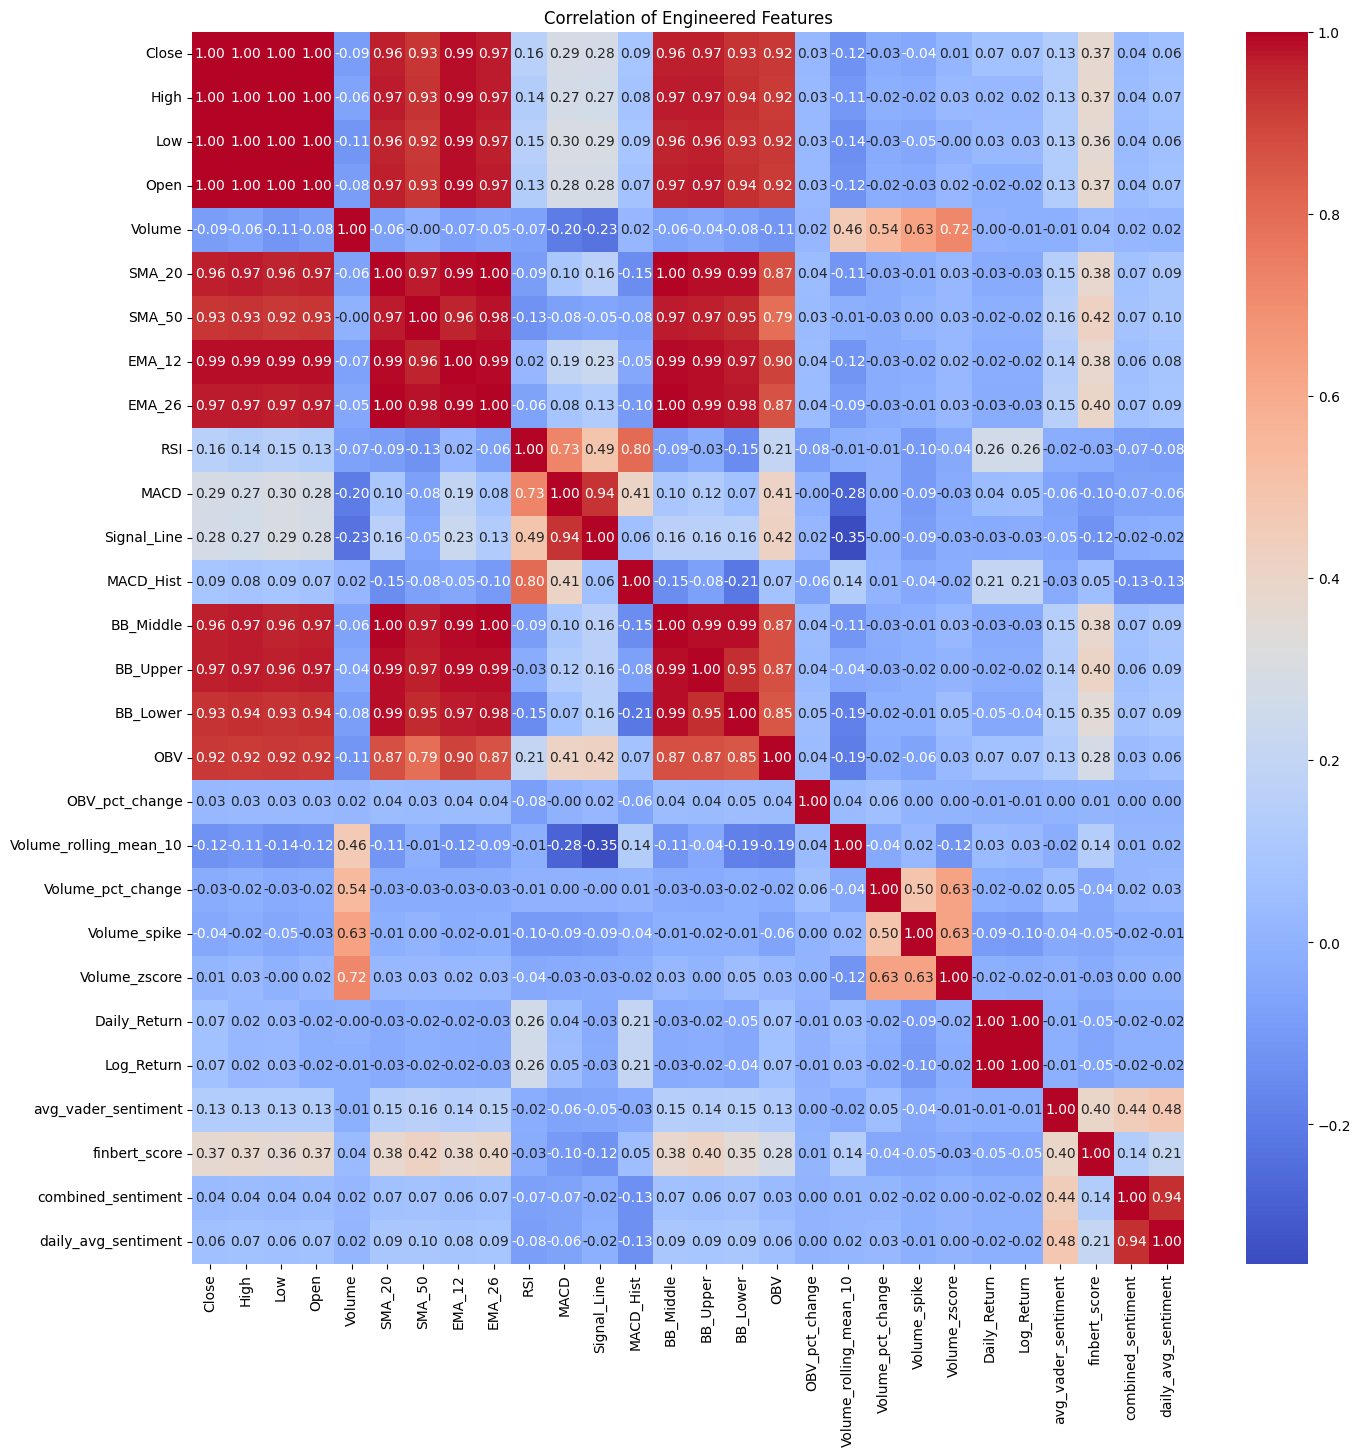

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = merged_df.corr(numeric_only=True)
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Engineered Features")
plt.show()

In [61]:
merged_df.describe()['Daily_Return']

count    499.000000
mean       0.000689
min       -0.060709
25%       -0.006470
50%        0.001075
75%        0.007442
max        0.075881
std        0.013687
Name: Daily_Return, dtype: float64

- Count    = 499 days (~2 years of trading data) /n
- Mean     = +0.000689 → ~0.07% daily return
- Median   = +0.001075 → Slight positive skew
- Min      = -0.0607   → -6.07% loss in a day
- Max      = +0.0759   → +7.59% gain in a day
- Std Dev  = 0.0137    → 1.37% typical daily movement